# Neural Network for CIFAR10 Classification
In this assignment, we will implement a two-layer fully-connected neural network for CIFAR10 classification.

## Data Preparation and Visualization

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import sys
# sys.path.append('/content/drive/MyDrive/HW4/')

In [3]:
# You may change `MODEL_DIR` to a existing local directory if you are not using Colab
MODEL_DIR = '/content/'
MODEL_PATH = MODEL_DIR + 'model.pt' if MODEL_DIR.endswith('/') else MODEL_DIR + '/model.pt'

In [4]:
from _utils import load_data, Dataset, Dataloader, FCL_Tests, ReLU_Tests, SCE_Tests, plot_curves, plot_result
import numpy as np
import matplotlib.pyplot as plt
import random
import torch

In [5]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
  print(f'Using torch {torch.__version__}, device = {torch.cuda.get_device_name(0)}')
else:
  DEVICE = 'cpu'
  print(f'Using torch {torch.__version__}, device = cpu')

Using torch 2.3.0+cu118, device = NVIDIA GeForce RTX 4070 Ti SUPER


In [6]:
images, labels, classes = load_data()

Files already downloaded and verified


In [7]:
print(f'Data type of images: {images.dtype} (value range: [{images.min()}, {images.max()}])')
print(f'Shape of images: {images.shape}')
print(f'Shape of labels: {labels.shape}')
print(f'Number of classes: {len(classes)}')
print(f'Classes: {classes}')

Data type of images: uint8 (value range: [0, 255])
Shape of images: (50000, 32, 32, 3)
Shape of labels: (50000,)
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


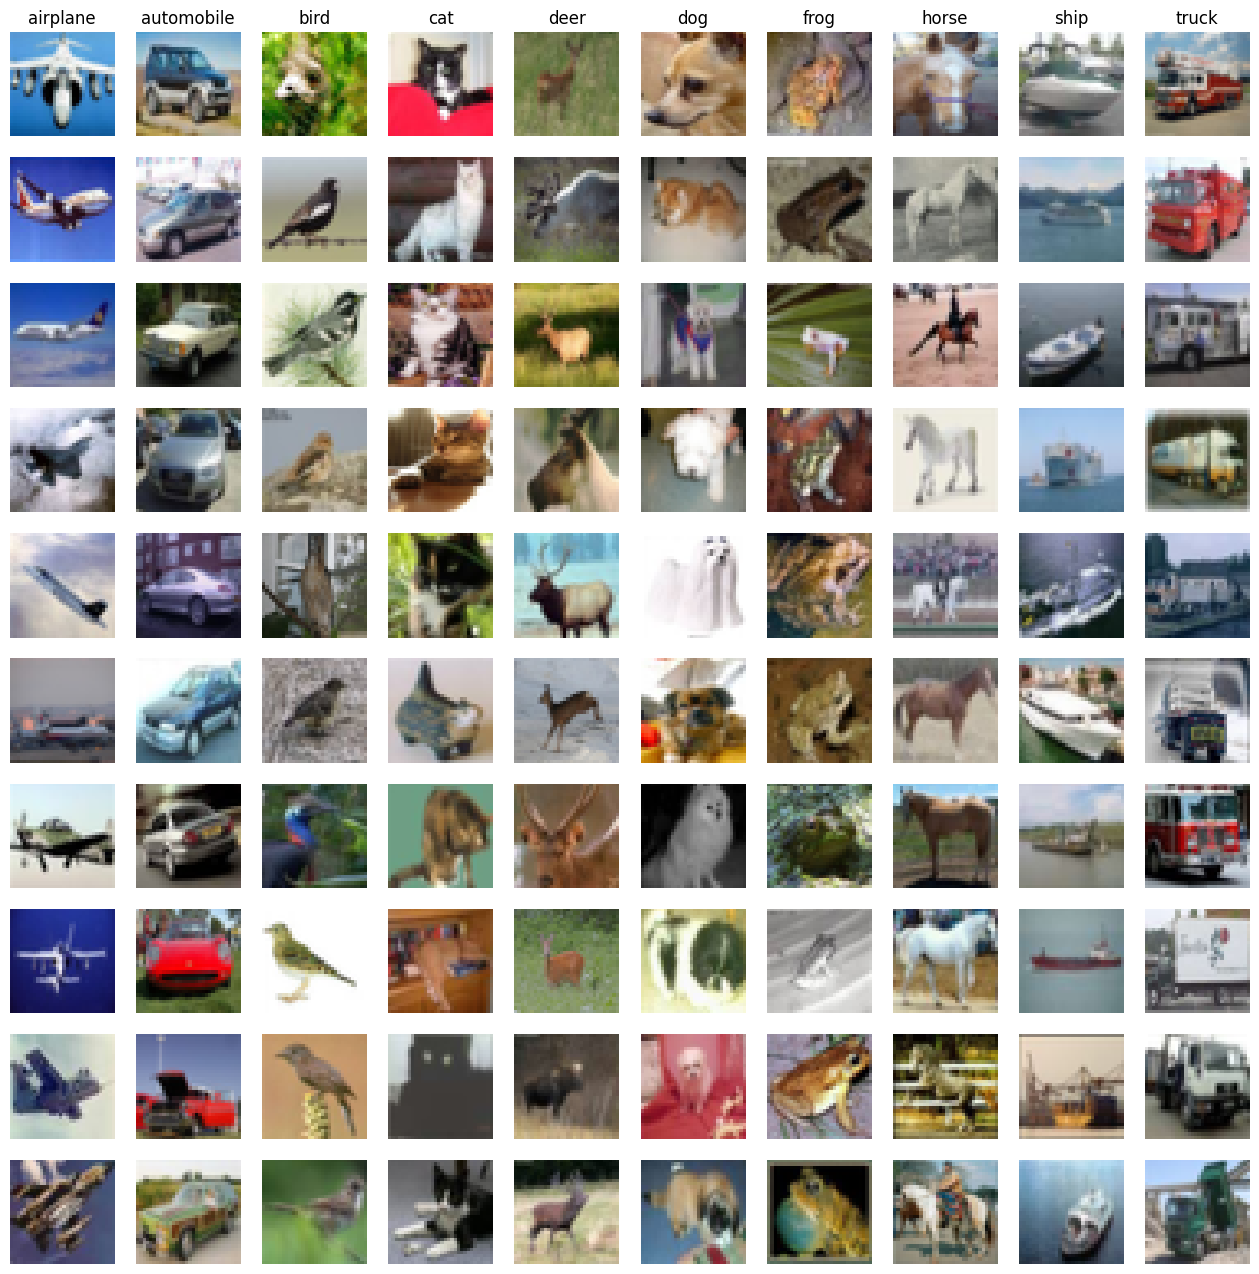

In [8]:
# Display samples of each class
plt.rcParams['figure.figsize'] = (16, 16)
num_classes = len(classes)
num_example = 10
for label, class_name in enumerate(classes):
  idxs = np.flatnonzero(labels == label)
  idxs = np.random.choice(idxs, num_example, replace=False)
  for i, idx in enumerate(idxs):
    plt_idx = i * num_classes + label + 1
    plt.subplot(num_example, num_classes, plt_idx)
    plt.imshow(images[idx]); plt.axis('off')
    if i == 0:
      plt.title(class_name)
plt.show()

In [9]:
# Data splitting with numpy array slicing
num_data = images.shape[0]
split_ratio = {'train': 0.6, 'valid': 0.2, 'test': 0.2}
num_valid_data = round(num_data * split_ratio['valid'])
num_test_data = round(num_data * split_ratio['test'])
num_train_data = num_data - (num_valid_data + num_test_data)

start_idx = 0
train_dataset = Dataset(images[start_idx:start_idx+num_train_data], labels[start_idx:start_idx+num_train_data])
start_idx += num_train_data

valid_dataset = Dataset(images[start_idx:start_idx+num_valid_data], labels[start_idx:start_idx+num_valid_data])
start_idx += num_valid_data

test_dataset = Dataset(images[start_idx:start_idx+num_test_data], labels[start_idx:start_idx+num_test_data])

print(f'Number of training data: {len(train_dataset)}')
print(f'Number of validation data: {len(valid_dataset)}')
print(f'Number of test data: {len(test_dataset)}')

Number of training data: 30000
Number of validation data: 10000
Number of test data: 10000


## Layer Definition
The architecture of our two-layer fully-connected neural network is like:

Input $\rightarrow$ Fully-Connected Layer1 $\rightarrow$ ReLU  $\rightarrow$ Fully-Connected Layer2 $\rightarrow$ Softmax

The learnable parameters are weights and bias of the two fully-connected layers. Let's name and clarify the parameters and their shapes:

1. Input data: $\mathbf{x}$, shape: ${N\times D}$
2. Weights of first fully-connected layer: $\mathbf{w_1}$, shape: ${D\times H}$
3. Bias of first fully-connected layer: $\mathbf{b_1}$, shape: ${H}$
4. Weights of second fully-connected layer: $\mathbf{w_2}$, shape: ${H\times C}$
5. Bias of second fully-connected layer: $\mathbf{b_2}$, shape: ${C}$
6. Output of the network: $\mathbf{S}$, shape: ${N\times C}$

And then we can simply express the function of our network by:
$$\mathbf{S} = \mathbf{w_2} * ReLU(\mathbf{w_1} * \mathbf{x} + \mathbf{b_1}) + \mathbf{b_2}$$

Since the two fully-connected layers do the same job, that is, multiply weights with input and then plus bias, we define a class called FullyConnectedLayer to implement a single fully-connected layer.

In [10]:
class FullyConnectedLayer(object):
  def __init__(self, device='cpu'):
    self.dv = device
  def forward(self, x, w, b):
    N, D = x.shape
    Dw, F = w.shape
    assert Dw == D, f'Wrong shape of weights, expected ({D},{F}) but got ({Dw},{F})'
    Fb = b.shape[0]
    assert Fb == F, f'Wrong shape of bias, expected ({F},) but got ({Fb},)'
    out = torch.zeros((N, F)).to(self.dv)
    ####################
    # TODO:
    # 1. Implement fully connected layer with `w` * `x` + `b` and store the result in variable `out`
    ####################
    # -----START OF YOUR CODE-----
    out = x @ w + b 
    # ------END OF YOUR CODE------
    self.cache = (x, w, b, out)
    return out
  def backward(self, backprop):
    N, F = backprop.shape
    dw = None
    db = None
    ####################
    # TODO:          
    # 1. Derive the gradient of bias, i.e., d(out)/d(b)
    # 2. Multiply d(out)/d(b) with `backprop` due to chain rule, and then store the AVERAGED result in variable `db`
    # 3. Then, derive the gradient of weights, i.e., d(out)/d(w)
    # 4. Multiply d(out)/d(w) with `backprop` due to chain rule, and then store the AVERAGED result in variable `dw`
    # HINT: Shapes of `db` and `dw` should be (F,) and (D, F) respectively
    ####################
    # -----START OF YOUR CODE-----
    x, w, b, out = self.cache
    dw = torch.zeros_like(w)
    db = torch.zeros_like(b)
    # ------END OF YOUR CODE------
    return dw, db

In [22]:
layer = FullyConnectedLayer()
FCL_Tests(layer)

Expected [[0.15344125, 0.30643143, 0.14575764, 0.15696668], [0.30307481, 0.44684002, 0.34205553, 0.21663028], [0.1468668, 0.20463775, 0.11047041, 0.13865895], [0.29312252, 0.19592198, 0.32729083, 0.12801923], [0.18424601, 0.13955896, 0.19113185, 0.09630192], [0.24164752, 0.40166434, 0.26348565, 0.19518408], [0.16991717, 0.32312752, 0.19463525, 0.14528135], [0.36079245, 0.48916752, 0.3925571, 0.25273089], [0.31717869, 0.53523705, 0.32277747, 0.27485827], [0.21985435, 0.31340653, 0.27487719, 0.13499362], [0.17594457, 0.35556504, 0.13378319, 0.20434426], [0.25657949, 0.35434448, 0.30212073, 0.16629209]] but got [[4.39296838 2.74169043 4.87948061 2.12806858]
 [4.15973249 2.6755472  5.12027539 2.06837809]
 [3.38263392 2.1764815  3.672563   1.60918374]] during backward of weights
Expected [0.4314191, 0.55524365, 0.47897169, 0.28509907] but got [[4.39296838 2.74169043 4.87948061 2.12806858]
 [4.15973249 2.6755472  5.12027539 2.06837809]
 [3.38263392 2.1764815  3.672563   1.60918374]] during b

ReLU (Rectified Linear Unit) is the currently most used non-linearity (or called activation function) in neural networks. Its formula as following:
$$ReLU(t) = max(0, t)$$

Since ReLU only allows positive values to be passed forward, any negative values of the input will not be able to propagate gradients during backpropagation.

In [12]:
class ReLU(object):
  def __init__(self):
    pass
  def forward(self, t):
    out = t.clone()
    ####################
    # TODO:
    # 1. Implement ReLU on `t` and store in variable `out`
    ####################
    # -----START OF YOUR CODE-----
    
    # ------END OF YOUR CODE------
    self.cache = (t, out)
    return out
  def backward(self, backprop):
    dt = torch.zeros_like(backprop)
    ####################
    # TODO:
    # 1. Derive d(out)/d(t)
    # 2. Multiply d(out)/d(t) with `backprop` due to chain rule, and then store the result in variable `dt`
    ####################
    # -----START OF YOUR CODE-----
    
    # ------END OF YOUR CODE------
    return dt

In [20]:
layer = ReLU()
ReLU_Tests(layer)

Expected [[0.09762701, 0.43037873, 0.20552675, 0.08976637, 0.0], [0.29178823, 0.0, 0.783546, 0.92732552, 0.0]] but got [[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904 ]
 [ 0.29178823 -0.12482558  0.783546    0.92732552 -0.23311696]] during forward
Expected [[1.0, 1.0, 1.0, 1.0, 0.0], [1.0, 0.0, 1.0, 1.0, 0.0]] but got [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]] during backward
Expected [[0.58345008, 0.05778984, 0.13608912, 0.85119328], [0.0, 0.0, 0.0, 0.66523969], [0.5563135, 0.7400243, 0.95723668, 0.59831713]] but got [[ 0.58345008  0.05778984  0.13608912  0.85119328]
 [-0.85792788 -0.8257414  -0.95956321  0.66523969]
 [ 0.5563135   0.7400243   0.95723668  0.59831713]] during forward
Expected [[1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 1.0], [1.0, 1.0, 1.0, 1.0]] but got [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] during backward
Expected [[0.0], [0.56105835], [0.0], [0.27984204], [0.0], [0.88933783], [0.04369664]] but got [[-0.07704128]
 [ 0.56105835]
 [-0.76345115]
 [ 0.27984204]

Softmax is used to convert a vector of real numbers into a probability distribution over classes. It can be expressed mathematically as:
$$softmax(\mathbf{S}_i)=\mathbf{p}_i=\frac{exp(\mathbf{S}_i)}{\sum_{j=1}^\mathbf{C}exp(\mathbf{S}_j)}$$
And the cross-entropy loss, on the other hand, is a measure of the difference between the predicted probability distribution and the true probability distribution of the labels. Let $\mathbf{y}$ be **one-hot encoded** ground-truth label, that is, its shape would be the same with output of the network. Cross-entropy loss formula is defined as:
$$CE = -\sum\mathbf{y}_i * log(\mathbf{p}_i)$$

In [14]:
class Softmax_CrossEntropy(object):
  def __init__(self):
    pass
  def forward(self, y, net_out):
    N, F = net_out.shape
    prob = torch.zeros_like(net_out)
    ####################
    # TODO:
    # 1. Implement Softmax and store the result in variable `prob`
    # HINT: Shape of `prob` should be (N, F)
    ####################
    # -----START OF YOUR CODE-----
    
    # ------END OF YOUR CODE------
    self.cache = (y, prob)
    pred_y = prob.argmax(dim=1)
    
    y_one_hot = torch.zeros_like(net_out)
    y_one_hot[np.arange(N), y] = 1
    loss = torch.zeros(1)
    ####################
    # TODO:
    # 1. Implement cross-entropy loss and store the result in variable `loss`
    ####################
    # -----START OF YOUR CODE-----
    
    # ------END OF YOUR CODE------
    return pred_y, loss
  def backward(self):
    y, grad = self.cache
    N, F = grad.shape
    ####################
    # TODO:
    # 1. Derive the gradient of `net_out` and store the result in variable `grad`
    ####################
    # -----START OF YOUR CODE-----
    
    # ------END OF YOUR CODE------
    return grad

In [15]:
layer = Softmax_CrossEntropy()
SCE_Tests(layer)

Expected [1, 0, 1, 1, 0] but got [0 0 0 0 0] during softmax prediction
Expected 0.69616684 but got [0.] during CE loss forward
Expected [[-0.10829966, 0.10829966], [0.1028932, -0.1028932], [0.08893354, -0.08893354], [-0.1223268, 0.1223268], [-0.07177634, 0.07177634]] but got [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]] during CE loss backward
Expected [1, 1, 1] but got [0 0 0] during softmax prediction
Expected 1.39425582 but got [0.] during CE loss forward
Expected [[0.06951818, 0.10829752, 0.06577236, -0.24358806], [-0.26984137, 0.11441441, 0.05055302, 0.10487394], [0.07148374, -0.23416956, 0.0749139, 0.08777191]] but got [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] during CE loss backward
Expected [1, 5, 2, 5, 2, 5, 4, 6, 1, 0] but got [0 0 0 0 0 0 0 0 0 0] during softmax prediction
Expected 1.96053199 but got [0.] during CE loss forward
Expected [[0.009638, 0.021478, -0.0859277, 0.01264197, 0.01087989, 0.01811235, 0.0131775], [0.01370346, 0.00790903, 0.01439456, -0.08568496, 0.01

## Network Definition

In [16]:
class Classifier(object):
  def __init__(self, dim_in, dim_hidden, dim_out, device='cpu'):
    self.dv = device
    np.random.seed(0)
    self.params = {'w1': torch.from_numpy(np.random.randn(dim_in, dim_hidden)*0.8).to(self.dv),
             'b1': torch.zeros(dim_hidden).to(self.dv),
             'w2': torch.from_numpy(np.random.randn(dim_hidden, dim_out)*0.8).to(self.dv),
             'b2': torch.zeros(dim_out).to(self.dv)}
    layer1 = FullyConnectedLayer()
    activation = ReLU()
    layer2 = FullyConnectedLayer()
    self.net = [layer1, activation, layer2]
    self.loss_func = Softmax_CrossEntropy()
  def save_model(self, path):
    torch.save(self.params, path)
  def load_model(self, path):
    checkpoint = torch.load(path, map_location=self.dv)
    self.params = checkpoint
  def training(self, train_dataloader, valid_dataloader, epochs=200, learning_rate=1e-3, learning_rate_decay=0.95, verbose=1):
    print(f'Training with batch_size={train_dataloader[0][0].shape[0]}, hidden_dim={self.params["w1"].shape[1]}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}')
    train_loss_log = []
    train_acc_log = []
    valid_loss_log = []
    valid_acc_log = []
    best_val_loss = None
    for epoch in range(epochs):
      if verbose > 0 and (epoch+1) % verbose == 0:
        print(f'Epoch {epoch+1}:')
      single_epoch_log = ''
      train_loss = 0.0
      train_corr = 0.0; train_eval = 0.0
      for batch_idx in range(len(train_dataloader)):
        ### Model Input and Loss Calculation ###
        batch_data = train_dataloader[batch_idx]
        batch_img, batch_label = batch_data
        layer1_out = self.net[0].forward(torch.from_numpy(batch_img).to(self.dv), self.params['w1'], self.params['b1'])
        layer1_out = self.net[1].forward(layer1_out)
        layer2_out = self.net[2].forward(layer1_out, self.params['w2'], self.params['b2'])
        pred_y, loss = self.loss_func.forward(batch_label, layer2_out)
        train_loss += loss.cpu().numpy()
        train_corr += torch.count_nonzero(pred_y == torch.from_numpy(batch_label).to(self.dv)).cpu().numpy()
        train_eval += batch_img.shape[0]
        ### Backpropagation and Optimization ###
        params_grad = {}
        dloss_dout2 = self.loss_func.backward()
        dout2_dw2, dout2_db2 = self.net[2].backward(dloss_dout2)
        params_grad['w2'] = dout2_dw2; params_grad['b2'] = dout2_db2
        dout2_dout1 = self.net[1].backward(dloss_dout2.mm(self.params['w2'].T))
        dout1_dw1, dout1_db1 = self.net[0].backward(dout2_dout1)
        params_grad['w1'] = dout1_dw1; params_grad['b1'] = dout1_db1
        ####################
        # TODO:
        # 1. Update model parameters, i.e., `self.params`, by gradient descent
        ####################
        # -----START OF YOUR CODE-----
        
        # ------END OF YOUR CODE------
      train_loss_log.append(train_loss/train_eval)
      train_acc_log.append(100*train_corr/train_eval)
      single_epoch_log += f'Training accuracy: {format(train_acc_log[-1], ".2f")}%, loss: {format(train_loss_log[-1], ".4f")}\n'
      train_dataloader.shuffle()

      valid_loss = 0.0
      valid_corr = 0.0; valid_eval = 0.0
      for batch_idx in range(len(valid_dataloader)):
        ### Model Input and Loss Calculation ###
        batch_data = valid_dataloader[batch_idx]
        batch_img, batch_label = batch_data
        layer1_out = self.net[0].forward(torch.from_numpy(batch_img).to(self.dv), self.params['w1'], self.params['b1'])
        layer1_out = self.net[1].forward(layer1_out)
        layer2_out = self.net[2].forward(layer1_out, self.params['w2'], self.params['b2'])
        pred_y, loss = self.loss_func.forward(batch_label, layer2_out)
        valid_loss += loss.cpu().numpy()
        valid_corr += torch.count_nonzero(pred_y == torch.from_numpy(batch_label).to(self.dv)).cpu().numpy()
        valid_eval += batch_img.shape[0]
      valid_loss_log.append(valid_loss/valid_eval)
      valid_acc_log.append(100*valid_corr/valid_eval)
      single_epoch_log += f'Validaion accuracy: {format(valid_acc_log[-1], ".2f")}%, loss: {format(valid_loss_log[-1], ".4f")}'
      if best_val_loss is None or valid_loss < best_val_loss:
        best_val_loss = valid_loss
        self.save_model(MODEL_PATH)
        if verbose == 1:
          single_epoch_log = '[MODEL SAVED]\n' + single_epoch_log
      if verbose > 0 and (epoch+1) % verbose == 0:
        print(single_epoch_log)
      learning_rate *= learning_rate_decay # update learning_rate every epoch
    return train_loss_log,train_acc_log,valid_loss_log,valid_acc_log
  def test(self, test_dataloader):
    total_corr = 0; total_eval = 0
    for batch_idx in range(len(test_dataloader)):
      ### Model Input ###
      batch_data = test_dataloader[batch_idx]
      batch_img, batch_label = batch_data
      layer1_out = self.net[0].forward(torch.from_numpy(batch_img).to(self.dv), self.params['w1'], self.params['b1'])
      layer1_out = self.net[1].forward(layer1_out)
      layer2_out = self.net[2].forward(layer1_out, self.params['w2'], self.params['b2'])
      pred_y, _ = self.loss_func.forward(batch_label, layer2_out)
      total_corr += torch.count_nonzero(pred_y == torch.from_numpy(batch_label).to(self.dv)).cpu().numpy()
      total_eval += batch_img.shape[0]
    print(f'Got {total_corr} correct prediction in {total_eval} test data, accuracy: {format((total_corr*1.0/total_eval)*100, ".2f")}%')

## Searching for Best Hyperparameters
Hyperparameters are configuration variables that set by users before model training. They influence the learning process and the final performance of the model. The goal of selecting optimal hyperparameters is to improve the model's accuracy and generalization ability.

Hyperparameters in this assignment include hidden layer size, batch size, learning rate, and learning rate decay. You may change candidate values of them in the following cells and observe which might be useful to optimize the model. Howerver,  as running the whole section may take a while, you are allowed to not running all of the cells.

In [17]:
# Configurations
IN_DIM = np.prod(images[0].shape)
OUT_DIM = len(classes)

In [18]:
# Hyperparameters
BATCH_SIZE = 16
LR = 1e-3
LR_DECAY = 0.95
HIDEEN_DIM = 64

In [19]:
lr_cand = [1e-2, 1e-3, 1e-4]
train_acc = []
valid_acc = []

for lr in lr_cand:
  train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE)
  valid_dataloader = Dataloader(valid_dataset, batch_size=BATCH_SIZE)
  model = Classifier(IN_DIM, HIDEEN_DIM, OUT_DIM, device=DEVICE)
  _, ta, _, va = model.training(train_dataloader, valid_dataloader, epochs=80, learning_rate=lr, learning_rate_decay=LR_DECAY, verbose=0)
  train_acc.append(ta); valid_acc.append(va)

plot_curves(lr_cand, train_acc, valid_acc)

Training with batch_size=16, hidden_dim=64, learning_rate=0.01, learning_rate_decay=0.95


TypeError: unsupported format string passed to numpy.ndarray.__format__

Training with batch_size=8, hidden_dim=64, learning_rate=0.001, learning_rate_decay=0.95
Training with batch_size=16, hidden_dim=64, learning_rate=0.001, learning_rate_decay=0.95
Training with batch_size=100, hidden_dim=64, learning_rate=0.001, learning_rate_decay=0.95


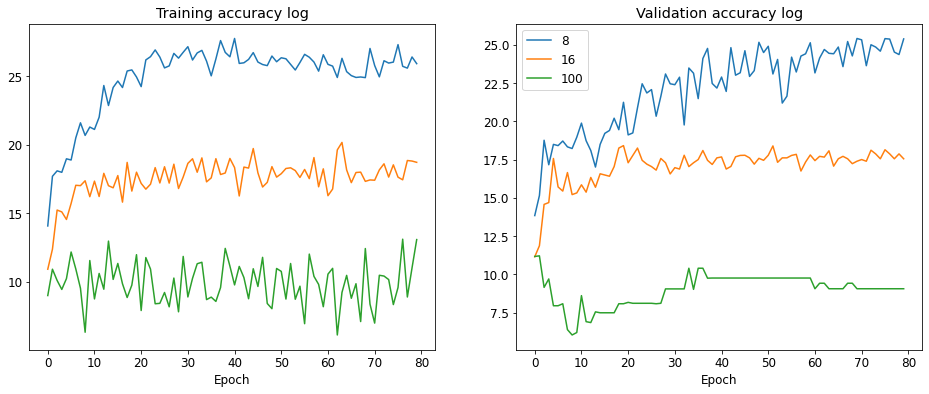

In [ ]:
bs_cand = [8, 16, 100]
train_acc = []
valid_acc = []

for bs in bs_cand:
  train_dataloader = Dataloader(train_dataset, batch_size=bs)
  valid_dataloader = Dataloader(valid_dataset, batch_size=bs)
  model = Classifier(IN_DIM, HIDEEN_DIM, OUT_DIM, device=DEVICE)
  _, ta, _, va = model.training(train_dataloader, valid_dataloader, epochs=80, learning_rate=LR, learning_rate_decay=LR_DECAY, verbose=0)
  train_acc.append(ta); valid_acc.append(va)

plot_curves(bs_cand, train_acc, valid_acc)

Training with batch_size=16, hidden_dim=32, learning_rate=0.001, learning_rate_decay=0.95
Training with batch_size=16, hidden_dim=64, learning_rate=0.001, learning_rate_decay=0.95
Training with batch_size=16, hidden_dim=256, learning_rate=0.001, learning_rate_decay=0.95


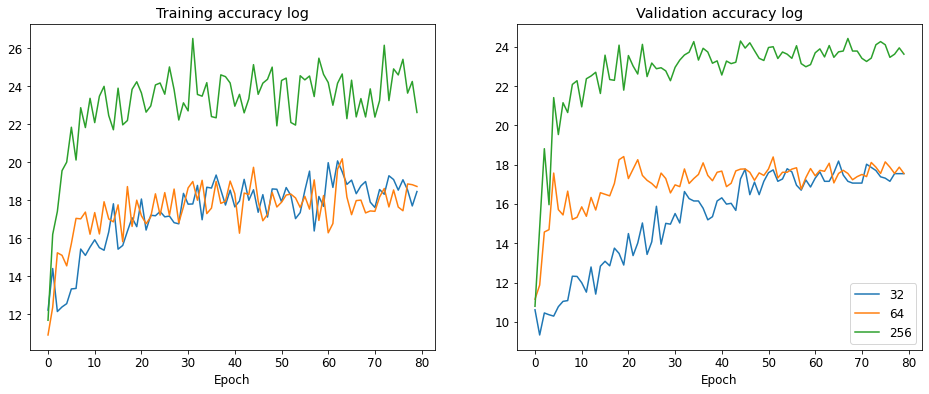

In [ ]:
hd_cand = [32, 64, 256]
train_acc = []
valid_acc = []

for hd in hd_cand:
  train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE)
  valid_dataloader = Dataloader(valid_dataset, batch_size=BATCH_SIZE)
  model = Classifier(IN_DIM, hd, OUT_DIM, device=DEVICE)
  _, ta, _, va = model.training(train_dataloader, valid_dataloader, epochs=80, learning_rate=LR, learning_rate_decay=LR_DECAY, verbose=0)
  train_acc.append(ta); valid_acc.append(va)

plot_curves(hd_cand, train_acc, valid_acc)

Training with batch_size=16, hidden_dim=64, learning_rate=0.001, learning_rate_decay=1.0
Training with batch_size=16, hidden_dim=64, learning_rate=0.001, learning_rate_decay=0.95
Training with batch_size=16, hidden_dim=64, learning_rate=0.001, learning_rate_decay=0.9


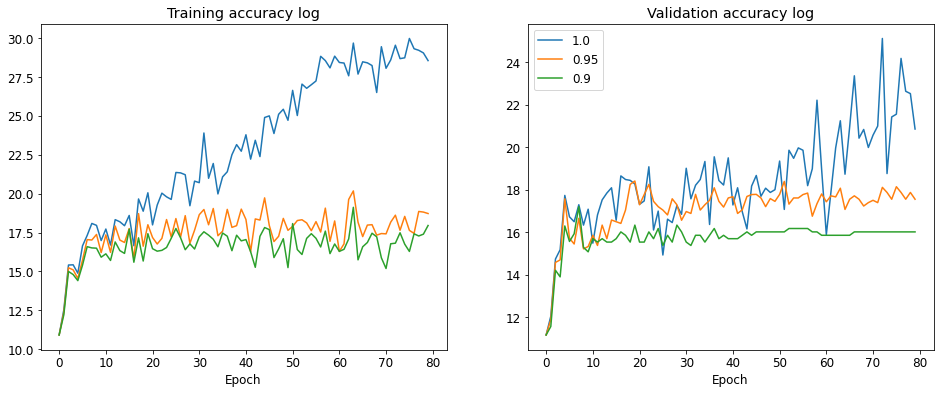

In [ ]:
lr_decay_cand = [1.0, 0.95, 0.9]
train_acc = []
valid_acc = []

for lrd in lr_decay_cand:
  train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE)
  valid_dataloader = Dataloader(valid_dataset, batch_size=BATCH_SIZE)
  model = Classifier(IN_DIM, HIDEEN_DIM, OUT_DIM, device=DEVICE)
  _, ta, _, va = model.training(train_dataloader, valid_dataloader, epochs=80, learning_rate=LR, learning_rate_decay=lrd, verbose=0)
  train_acc.append(ta); valid_acc.append(va)

plot_curves(lr_decay_cand, train_acc, valid_acc)

## Training with Best Hyperparameters


In [ ]:
# Configurations
IN_DIM = np.prod(images[0].shape)
OUT_DIM = len(classes)

In [ ]:
# Please set your hyperparameters here
BATCH_SIZE = 
LR = 
LR_DECAY = 
HIDEEN_DIM = 

Training with batch_size=16, hidden_dim=128, learning_rate=0.002, learning_rate_decay=0.98
Epoch 1:
[MODEL SAVED]
Training accuracy: 14.37%, loss: 4.2484
Validaion accuracy: 11.43%, loss: 3.6242
Epoch 2:
[MODEL SAVED]
Training accuracy: 17.21%, loss: 2.9634
Validaion accuracy: 13.66%, loss: 2.9900
Epoch 3:
[MODEL SAVED]
Training accuracy: 18.32%, loss: 2.4795
Validaion accuracy: 14.20%, loss: 2.7162
Epoch 4:
[MODEL SAVED]
Training accuracy: 18.12%, loss: 2.2688
Validaion accuracy: 17.47%, loss: 2.3202
Epoch 5:
[MODEL SAVED]
Training accuracy: 19.68%, loss: 2.0392
Validaion accuracy: 17.48%, loss: 2.1398
Epoch 6:
[MODEL SAVED]
Training accuracy: 21.07%, loss: 1.8612
Validaion accuracy: 17.05%, loss: 2.0011
Epoch 7:
[MODEL SAVED]
Training accuracy: 19.94%, loss: 1.8074
Validaion accuracy: 17.84%, loss: 1.8933
Epoch 8:
[MODEL SAVED]
Training accuracy: 22.22%, loss: 1.6480
Validaion accuracy: 20.35%, loss: 1.7868
Epoch 9:
[MODEL SAVED]
Training accuracy: 21.58%, loss: 1.5314
Validaion accu

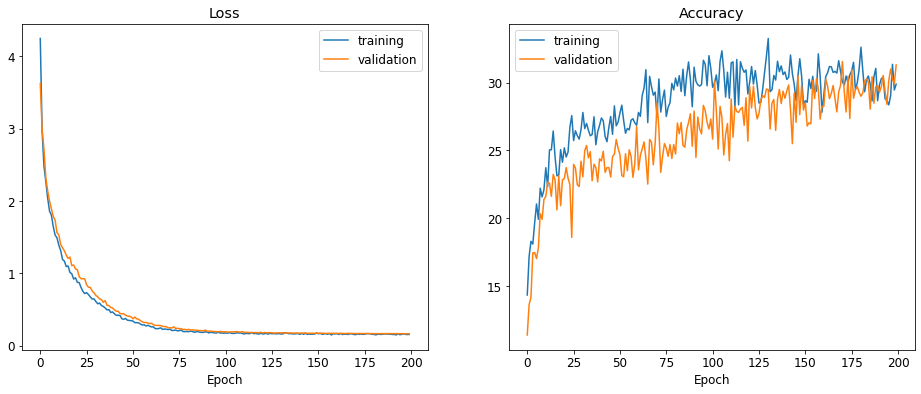

In [ ]:
train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE)
valid_dataloader = Dataloader(valid_dataset, batch_size=BATCH_SIZE)
model = Classifier(IN_DIM, HIDEEN_DIM, OUT_DIM, device=DEVICE)
train_loss, train_acc, valid_loss, valid_acc = model.training(train_dataloader, valid_dataloader, learning_rate=LR, learning_rate_decay=LR_DECAY)
plot_result(train_loss, train_acc, valid_loss, valid_acc)

Test the model with test_dataset. <font color='red'>The test accuracy must reach at least 28%.</font>

In [ ]:
test_dataloader = Dataloader(test_dataset)
model.load_model(MODEL_PATH)
model.test(test_dataloader)

Got 2879 correct prediction in 10000 test data, accuracy: 28.79%
